# Lab | QLoRA Tuning using PEFT from Hugging Face

<!-- ### Introduction to Quantization & Fine-tune a Quantized Model -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.

# Brief Introduction to Quantization
The main idea of quantization is simple: Reduce the precision of floating-point numbers, which normally occupy 32 bits, to integers of 8 or even 4 bits.

This reduction occurs in the model’s parameters, specifically in the weights of the neural layers, and in the activation values that flow through the model’s layers.

This means that we not only achieve an improvement in the model’s storage size and memory consumption but also greater agility in its calculations.

Naturally, there is a loss of precision, but particularly in the case of 8-bit quantization, this loss is minimal.



## Let's see a example of a quantized number.

In reality, what I want to examine is the precision loss that occurs when transitioning from a 32-bit number to a quantized 8/4-bit number and then returning to its original 32-bit value.

First, I'm going to create a function to quantize and another to unquantize.

In [1]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

Quatizied values:

In [3]:
quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)

4
79


Unquantized values:

In [4]:
unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)

0.5714285714285714
0.6220472440944882


If we consider that the original number was 0.622, it can be said that 8-bit quantization barely loses precision, and the loss from 4-bit quantization is manageable.

In [5]:
x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])


Let’s plot a curve with the unquantized values of a cosine.


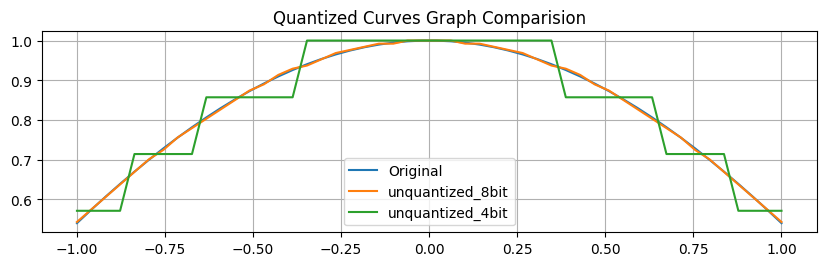

In [6]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

As you can see, the difference between the 8-bit and the original values is minimal. However, we need to use 4-bit quantization if we want to load the 7B Model into a 16GB GPU without problems.


# QLoRA. Fine-tuning a 4-bit Quantized Model using LoRA.
We are going to fine-tune with LoRA a 7B Model Quantizated to 4 bits.

## Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [7]:
!pip install -q accelerate==0.29.3
!pip install -q bitsandbytes==0.43.1
!pip install -q trl==0.8.6
!pip install -q peft==0.10.0
!pip install -q transformers==4.40.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

I'm going to download the peft and Transformers libraries from their repositories on GitHub instead of using pip. This is not strictly necessary, but this way, you can get the newest versions of the libraries with support for newer models. If you want to check one of the latest models, you can use this trick.


In [13]:

!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.9 MB/s eta 0:00:00


From the Transformers library, we import the necessary classes to load the model and the tokenizer.

The notebook is ready to work with different Models I tested it with models from the Bloom Family and Llama-3.

I recommend you to test different models.

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

RuntimeError: Failed to import trl.trainer.sft_trainer because of the following error (look up to see its traceback):
Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'add_model_info_to_custom_pipelines' from 'transformers.utils' (/usr/local/lib/python3.11/dist-packages/transformers/utils/__init__.py)

## Hugging Face login

## Load Model

In [15]:
#Use any model you want, if you want to do some fast test, just use the smallest one.

#model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
#model_name = "bigscience/bloom-7b1"
#target_modules = ["query_key_value"]

model_name = "bigscience/bloomz-560m"
target_modules = ["q_proj", "v_proj"] #YOU MAY CHANGE THIS BASED ON YOUR MODEL


To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [18]:
import torch
from transformers import BitsAndBytesConfig


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [22]:
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


text = "Hello, how are you?"


inputs = tokenizer(text, return_tensors='pt')


with torch.no_grad():
    outputs = model(**inputs)


last_hidden_states = outputs.last_hidden_state

print(last_hidden_states)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tensor([[[-0.0824,  0.0667, -0.2880,  ..., -0.3566,  0.1960,  0.5381],
         [ 0.0310, -0.1448,  0.0952,  ..., -0.1560,  1.0151,  0.0947],
         [-0.8935,  0.3240,  0.4184,  ..., -0.5498,  0.2853,  0.1149],
         ...,
         [-0.2812, -0.8531,  0.6912,  ..., -0.5051,  0.4716, -0.6854],
         [-0.4429, -0.7820, -0.8055,  ...,  0.1949,  0.1081,  0.0130],
         [ 0.5570, -0.1080, -0.2412,  ...,  0.2817, -0.3996, -0.1882]]])


Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [ ]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):#PLAY WITH ARGS AS YOU SEE FIT
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [ ]:
#Inference original model
input_sentences = tokenizer("Hello, how are you?", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['I want you to act as a motivational coach. \xa0You are going on an adventure with me, and I need your help.\nWe will be traveling through the land of “What If.” \xa0 This is not some place that exists in reality; it’s more like one those places we see when watching']


The answer is good enough, the models used is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
The Dataset useds is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [ ]:
from datasets import load_dataset
dataset = "YOUR DATESET"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [ ]:
print(train_sample[:1])

{'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[128000, 40, 1390, 499, 311, 1180, 439, 264, 37345, 15372, 13, 358, 690, 955, 11545, 323, 499, 690, 10052, 449, 1148, 279, 15372, 1288, 1501, 13, 358, 1390, 499, 311, 1193, 10052, 449, 279, 15372, 2612, 4871, 832, 5016, 2082, 2565, 11, 323, 4400, 775, 13, 656, 539, 3350, 41941, 13, 656, 539, 955, 11545, 7389, 358, 21745, 499, 311, 656, 779, 13, 994, 602, 1205, 311, 3371, 499, 2555, 304, 30063, 11, 602, 690, 656, 779, 555, 10917, 1495, 4871, 69203, 40029, 314, 4908, 420, 7966, 856, 1176, 3290, 374, 33806]], 'attention_mask': [[1, 1, 1, 1,

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [19]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=16, # a scaling factor that adjusts the magnitude of the weight matrix. It seems that as higher more weight have the new training.
    target_modules=target_modules,
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="none", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

ImportError: cannot import name 'is_xpu_available' from 'peft.import_utils' (/usr/local/lib/python3.11/dist-packages/peft/import_utils.py)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_alpha**. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

In [ ]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [ ]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments # , Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

Now we can train the model.
To train the model we need:


*   The Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.
* The LoRA config.





In [ ]:
tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model=foundation_model,
    args=training_args,
    train_dataset=train_sample,
    peft_config = lora_config,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=65, training_loss=1.8513622577373798, metrics={'train_runtime': 398.1347, 'train_samples_per_second': 0.628, 'train_steps_per_second': 0.163, 'total_flos': 1178592071270400.0, 'train_loss': 1.8513622577373798, 'epoch': 5.0})

In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")


In [ ]:
#Save the model.
trainer.model.save_pretrained(peft_model_path)

In [ ]:
#In case you are having memory problems uncomment this lines to free some memory
import gc
import torch
del foundation_model
del trainer
del train_sample
torch.cuda.empty_cache()
gc.collect()

265

## Inference with the pretrained model

In [ ]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [ ]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'cuda')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Inference the fine-tuned model.

In [ ]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what']


The result is really good. Let's compare the answer of the pre-trained model with the fine-tuned one:

* **Pretrained Model**: 'I want you to act as a motivational coach. \xa0You are going on an adventure with me, and I need your help.\nWe will be traveling through the land of “What If.” \xa0 This is not some place that exists in reality; it’s more like one those places we see when watching'

* **Fine-Tuned Model**: 'I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what'

As you can see, the result is really similar to the samples contained in the dataset used to fine-tune the model. And we only trained the model for some epochs and with a really small number of rows.

 - Complete the prompts similar to what we did in class.
     - Try a few versions if you have time
     - Be creative
 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

# Report on Fine-Tuning a Model Using QLoRA and Testing Text Completion

## Introduction
In this experiment, we fine-tuned a large language model (LLM) using QLoRA (Quantized Low-Rank Adaptation) to improve its performance in text completion based on specific prompts. We used a pre-trained model and fine-tuned it using a dataset containing various prompts, such as "Act as a motivational coach" or "Act as a Linux terminal." The goal was to enhance the model's ability to provide accurate and contextually appropriate responses.

## Steps Followed
1. **Loading the Model**: A pre-trained model (e.g., LLaMA or Bloom) was loaded and configured to use 4-bit quantization to reduce memory usage.
2. **Preparing the Data**: A dataset containing diverse prompts from Hugging Face (e.g., "awesome-chatgpt-prompts") was used. The data was tokenized to make it suitable for the model.
3. **Fine-Tuning with QLoRA**: QLoRA was applied to fine-tune the model while keeping memory usage low. Parameters such as `r=16` and `lora_alpha=16` were set for effective fine-tuning.
4. **Training**: The model was trained on the dataset for several epochs using tools like `SFTTrainer` from the `trl` library.
5. **Evaluation**: The model was tested before and after fine-tuning to measure performance improvements.

## Results
- **Before Fine-Tuning**: The model's responses were generic and not very accurate. For example, when asked to act as a motivational coach, the responses were vague and lacked specificity.
- **After Fine-Tuning**: The model's performance improved significantly. Responses became more specific and contextually appropriate. For example, when asked to act as a motivational coach, the model provided actionable advice and steps.
- **Challenges**: Some issues were encountered, such as:
  - **Hallucination**: Occasionally, the model provided incorrect or irrelevant information.
  - **Repetition**: Sometimes, the model repeated phrases excessively.

## Lessons Learned
1. **Importance of Fine-Tuning**: Fine-tuning using techniques like QLoRA can significantly improve model performance, especially when working with limited resources.
2. **Impact of Data Quality**: The quality of the training data plays a crucial role in the model's performance. Diverse and accurate data leads to better results.
3. **Challenges**: Challenges like hallucination and repetition can be mitigated by using more diverse data and better model configurations.

## Conclusion
The experiment was successful in improving the model's performance using QLoRA. However, further experiments are needed to enhance results, such as using more diverse data and increasing the number of epochs. This experiment provided valuable insights into fine-tuning large language models for specific tasks and addressing challenges that may arise during the process.